# Maximum-minimum driving force analysis

In this notebook we use the max-min driving force analysis (MMDFA) to find
optimal concentrations for the metabolites in glycolysis to ensure that the
smallest driving force across all the reactions in the model is as large as
possible. For more information, see Flamholz, Avi, et al.  "Glycolytic
strategy as a tradeoff between energy yield and protein cost.", Proceedings
of the National Academy of Sciences 110.24 (2013): 10039-10044.

In [1]:
using COBREXA, GLPK, Tulip

Let's load the core E. coli model

In [2]:
model = load_model("e_coli_core.json")

Metabolic model of type JSONModel
sparse([9, 51, 55, 64, 65, 34, 44, 59, 66, 64  …  20, 22, 23, 25, 16, 17, 34, 44, 57, 59], [1, 1, 1, 1, 1, 2, 2, 2, 2, 3  …  93, 93, 94, 94, 95, 95, 95, 95, 95, 95], [1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0  …  1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 72, 95)
Number of reactions: 95
Number of metabolites: 72


We need some thermodynamic data. You can get reaction Gibbs free energies (ΔG⁰) from
e.g. [eQuilibrator](https://equilibrator.weizmann.ac.il/), possibly using the
[Julia wrapper](https://github.com/stelmo/eQuilibrator.jl) that allows you to
automate this step. Here, we make a dictionary that maps the reaction IDs to
calculated Gibbs free energy of reaction for each reaction (including the transporters).

In [3]:
reaction_standard_gibbs_free_energies = Dict( # kJ/mol
    "ACALD" => -21.26,
    "PTAr" => 8.65,
    "ALCD2x" => 17.47,
    "PDH" => -34.24,
    "PYK" => -24.48,
    "CO2t" => 0.00,
    "MALt2_2" => -6.83,
    "CS" => -39.33,
    "PGM" => -4.47,
    "TKT1" => -1.49,
    "ACONTa" => 8.46,
    "GLNS" => -15.77,
    "ICL" => 9.53,
    "FBA" => 23.37,
    "SUCCt3" => -43.97,
    "FORt2" => -3.42,
    "G6PDH2r" => -7.39,
    "AKGDH" => -28.23,
    "TKT2" => -10.31,
    "FRD7" => 73.61,
    "SUCOAS" => -1.15,
    "FBP" => -11.60,
    "ICDHyr" => 5.39,
    "AKGt2r" => 10.08,
    "GLUSy" => -47.21,
    "TPI" => 5.62,
    "FORt" => 13.50,
    "ACONTb" => -1.62,
    "GLNabc" => -30.19,
    "RPE" => -3.38,
    "ACKr" => 14.02,
    "THD2" => -33.84,
    "PFL" => -19.81,
    "RPI" => 4.47,
    "D_LACt2" => -3.42,
    "TALA" => -0.94,
    "PPCK" => 10.65,
    "ACt2r" => -3.41,
    "NH4t" => -13.60,
    "PGL" => -25.94,
    "NADTRHD" => -0.01,
    "PGK" => 19.57,
    "LDH_D" => 20.04,
    "ME1" => 12.08,
    "PIt2r" => 10.41,
    "ATPS4r" => -37.57,
    "PYRt2" => -3.42,
    "GLCpts" => -45.42,
    "GLUDy" => 32.83,
    "CYTBD" => -59.70,
    "FUMt2_2" => -6.84,
    "FRUpts2" => -42.67,
    "GAPD" => 0.53,
    "H2Ot" => 0.00,
    "PPC" => -40.81,
    "NADH16" => -80.37,
    "PFK" => -18.54,
    "MDH" => 25.91,
    "PGI" => 2.63,
    "O2t" => 0.00,
    "ME2" => 12.09,
    "GND" => 10.31,
    "SUCCt2_2" => -6.82,
    "GLUN" => -14.38,
    "ETOHt2r" => -16.93,
    "ADK1" => 0.38,
    "ACALDt" => 0.00,
    "SUCDi" => -73.61,
    "ENO" => -3.81,
    "MALS" => -39.22,
    "GLUt2r" => -3.49,
    "PPS" => -6.05,
    "FUM" => -3.42,
);

In general we cannot be certain that all fluxes will be positive for a given flux
solution. This poses problems for systematically enforcing that ΔᵣG ≤ 0 for each reaction,
because it implicitly assumes that all fluxes are positive, as done in the original
formulation of MMDF. In `max_min_driving_force` we instead enforce ΔᵣG ⋅ vᵢ ≤ 0, where vᵢ
is the flux of reaction i. By default all fluxes are assumed to be positive, but by
supplying thermodynamically consistent flux solution it is possible to drop this implicit
assumption and makes it easier to directly incorporate the max min driving force into
non-customized models. Here, customized model means a model written such that a negative
ΔᵣG is associated with each positive flux in the model, and only positive fluxes are used
by the model.

In [4]:
flux_solution = flux_balance_analysis_dict( # find a thermodynamically consistent solution
    model,
    GLPK.Optimizer;
    modifications = [add_loopless_constraints()],
)

Dict{String, Float64} with 95 entries:
  "ACALD"       => 0.0
  "PTAr"        => 0.0
  "ALCD2x"      => 0.0
  "PDH"         => 9.28253
  "PYK"         => 1.75818
  "CO2t"        => -22.8098
  "EX_nh4_e"    => -4.76532
  "MALt2_2"     => 0.0
  "CS"          => 6.00725
  "PGM"         => -14.7161
  "TKT1"        => 1.49698
  "EX_mal__L_e" => 0.0
  "ACONTa"      => 6.00725
  "EX_pi_e"     => -3.2149
  "GLNS"        => 0.223462
  "ICL"         => 0.0
  "EX_o2_e"     => -21.7995
  "FBA"         => 7.47738
  "EX_gln__L_e" => 0.0
  ⋮             => ⋮

Run max min driving force analysis with some reasonable constraints on metabolite
concentration bounds. To remove protons and water from the concentration calculations, we
explicitly specify their IDs. Note, protons and water need to be removed from the
concentration calculation of the optimization problem, because the Gibbs free energies of
biochemical reactions are measured at constant pH, so proton concentration is fixed, and
reactions occur in aqueous environments, hence water concentration does not change.

In [5]:
sol = max_min_driving_force(
    model,
    reaction_standard_gibbs_free_energies,
    Tulip.Optimizer;
    flux_solution = flux_solution,
    proton_ids = ["h_c", "h_e"],
    water_ids = ["h2o_c", "h2o_e"],
    concentration_ratios = Dict(
        ("atp_c", "adp_c") => 10.0,
        ("nadh_c", "nad_c") => 0.13,
        ("nadph_c", "nadp_c") => 1.3,
    ),
    concentration_lb = 1e-6, # M
    concentration_ub = 100e-3, # M
    ignore_reaction_ids = [
        "H2Ot", # ignore water transporter
    ],
)

sol.mmdf

1.7695541740687368

Next, we plot the results to show how the concentrations can be used to ensure that
each reach proceeds "down hill" (ΔᵣG < 0) and that the driving force is as
large as possible across all the reactions in the model. Compare this to the
driving forces at standard conditions. Note, we only plot glycolysis for simplicity.

We additionally scale the fluxes according to their stoichiometry in the
pathway. From the output, we can clearly see that that metabolite concentrations
play a large role in ensuring the thermodynamic consistency of in vivo reactions.

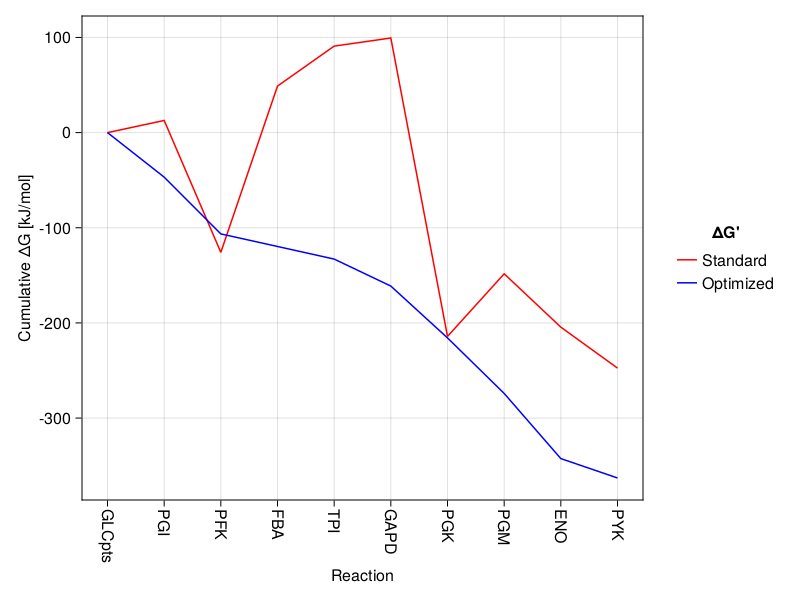

In [6]:
rids = ["GLCpts", "PGI", "PFK", "FBA", "TPI", "GAPD", "PGK", "PGM", "ENO", "PYK"] # glycolysis
rid_rf = [flux_solution[rid] for rid in rids]
dg_standard = cumsum([
    reaction_standard_gibbs_free_energies[rid] * flux_solution[rid] for rid in rids
])
dg_standard .-= first(dg_standard)
dg_opt = cumsum([sol.dg_reactions[rid] * flux_solution[rid] for rid in rids])
dg_opt .-= first(dg_opt)

using CairoMakie

fig = Figure();
ax = Axis(
    fig[1, 1],
    xticklabelrotation = -pi / 2,
    xlabel = "Reaction",
    ylabel = "Cumulative ΔG [kJ/mol]",
);

lines!(ax, 1:length(rids), dg_standard; color = :red, label = "Standard")
lines!(ax, 1:length(rids), dg_opt, color = :blue, label = "Optimized")
ax.xticks = (1:length(rids), rids)
fig[1, 2] = Legend(fig, ax, "ΔG'", framevisible = false)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*